In [191]:

import os
import pandas as pd
import yaml
import csv

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import seaborn as sns
from scipy.stats import sem, t

sns.set_theme()

In [168]:
# root_dir = r".\results\2024Apr11-215305_configs" # adam
root_dir = r".\results\2024Apr13-162228_configs" # sgd


In [169]:
def collect_experiment_data(root_dir):
    """
    Collects experiment data and selected parameters from configuration files across multiple runs.

    Parameters:
    - root_dir: The root directory where experiment results are stored.

    Returns:
    - A pandas DataFrame containing the collected data and parameters.
    """
    all_data = []

    # Walk through the directory structure
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith("loss_record.csv"):
                # Path to the current file
                file_path = os.path.join(subdir, file)
                # Read the loss record CSV file
                df = pd.read_csv(file_path)

                # Load the corresponding cfg.yaml file to get parameters
                cfg_path = os.path.join(subdir, "cfg.yaml")
                with open(cfg_path, "r") as cfg_file:
                    cfg_data = yaml.safe_load(cfg_file)

                # Extract needed parameters
                run_id = cfg_data.get("run_id")
                tau = cfg_data["tau"]
                min_samples = cfg_data["min_samples"]

                # Add parameters as new columns to the DataFrame
                df["run_id"] = run_id
                df["tau"] = tau
                df["min_samples"] = min_samples

                # Append to the list of all data
                all_data.append(df)

    # Concatenate all data into a single DataFrame
    return pd.concat(all_data, ignore_index=True)


combined_data = collect_experiment_data(root_dir)
combined_data

aggregated_df = (
    combined_data.groupby(["run_id", "tau", "min_samples"])
    .agg({"epoch": "max"})
    .reset_index()
)

aggregated_df

,run_id,tau,min_samples,epoch
0,0,0.001,10,29
1,0,0.010,10,29
2,0,0.100,10,29
3,0,1.000,10,29
4,1,0.001,10,29
...,...,...,...,...
75,18,1.000,10,29
76,19,0.001,10,29
77,19,0.010,10,29
78,19,0.100,10,29


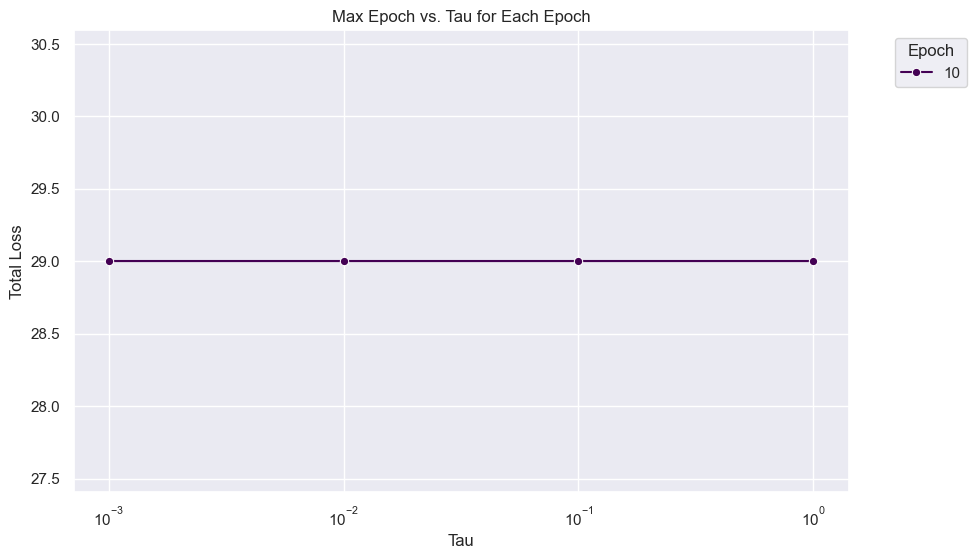

In [170]:
plt.figure(figsize=(10, 6))
# Assuming you want to plot the loss for the last epoch of each run, you can filter or aggregate the data as needed
sns.lineplot(
    data=aggregated_df,
    x="tau",
    y="epoch",
    hue="min_samples",
    palette="viridis",
    marker="o",
)
plt.xlabel("Tau")
plt.ylabel("Total Loss")
plt.xscale("log")
# plt.yscale('log')
plt.title("Max Epoch vs. Tau for Each Epoch")
plt.legend(title="Epoch", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

In [171]:
def collect_bellman_errors(root_dir):
    """
    Collects Bellman error values and selected parameters from configuration files across multiple runs.

    Parameters:
    - root_dir: The root directory where experiment results are stored.

    Returns:
    - A pandas DataFrame containing the collected Bellman errors and parameters.
    """
    all_errors = []

    # Walk through the directory structure
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file == "bellman_error.csv":
                # Path to the current file
                file_path = os.path.join(subdir, file)
                # Read the Bellman error values from the CSV file
                with open(file_path, "r") as error_file:
                    csv_reader = csv.reader(error_file)
                    headers = next(csv_reader)  # Skip header row
                    values = next(csv_reader)  # Get the values

                # Map the values to their corresponding headers
                bellman_errors = dict(zip(headers, values))
                validation_error = float(bellman_errors['validation_error'])
                training_error = float(bellman_errors['training_error'])

                # Load the corresponding cfg.yaml file to get parameters
                cfg_path = os.path.join(subdir, "cfg.yaml")
                with open(cfg_path, "r") as cfg_file:
                    cfg_data = yaml.safe_load(cfg_file)

                # Extract needed parameters
                run_id = cfg_data.get("run_id")
                tau = cfg_data["tau"]
                min_samples = cfg_data["min_samples"]

                # Create a dictionary with the collected data
                error_data = {
                    "run_id": run_id,
                    "tau": tau,
                    "min_samples": min_samples,
                    "validation_error": validation_error,
                    "training_error": training_error
                }

                # Append to the list of all errors
                all_errors.append(error_data)

    # Convert the list of dictionaries to a DataFrame
    return pd.DataFrame(all_errors)


# Example usage
bellman_errors_df = collect_bellman_errors(root_dir)
bellman_errors_df



,run_id,tau,min_samples,validation_error,training_error
0,0,0.001,10,0.000632,0.001883
1,1,0.001,10,0.008710,0.002474
2,10,0.001,10,NaN,NaN
3,11,0.001,10,0.016285,0.001815
4,12,0.001,10,0.005887,0.001528
...,...,...,...,...,...
75,5,1.000,10,0.001622,0.000942
76,6,1.000,10,0.000173,0.000887
77,7,1.000,10,0.000316,0.000717
78,8,1.000,10,0.002020,0.001285


In [172]:
bellman_errors_df_melted = pd.melt(bellman_errors_df, id_vars=['run_id', 'tau', 'min_samples'], value_vars=['validation_error', 'training_error'], var_name='error_type', value_name='error_value')
bellman_errors_df_melted

,run_id,tau,min_samples,error_type,error_value
0,0,0.001,10,validation_error,0.000632
1,1,0.001,10,validation_error,0.008710
2,10,0.001,10,validation_error,NaN
3,11,0.001,10,validation_error,0.016285
4,12,0.001,10,validation_error,0.005887
...,...,...,...,...,...
155,5,1.000,10,training_error,0.000942
156,6,1.000,10,training_error,0.000887
157,7,1.000,10,training_error,0.000717
158,8,1.000,10,training_error,0.001285


In [173]:
# # bellman_errors_df_filtered = bellman_errors_df[bellman_errors_df["tau"]!=0.01]
# bellman_errors_df_filtered = bellman_errors_df[bellman_errors_df["min_samples"] != 0]

In [174]:
# bellman_errors_df_filtered["min_samples"] = bellman_errors_df_filtered[
#     "min_samples"
# ].astype(str)

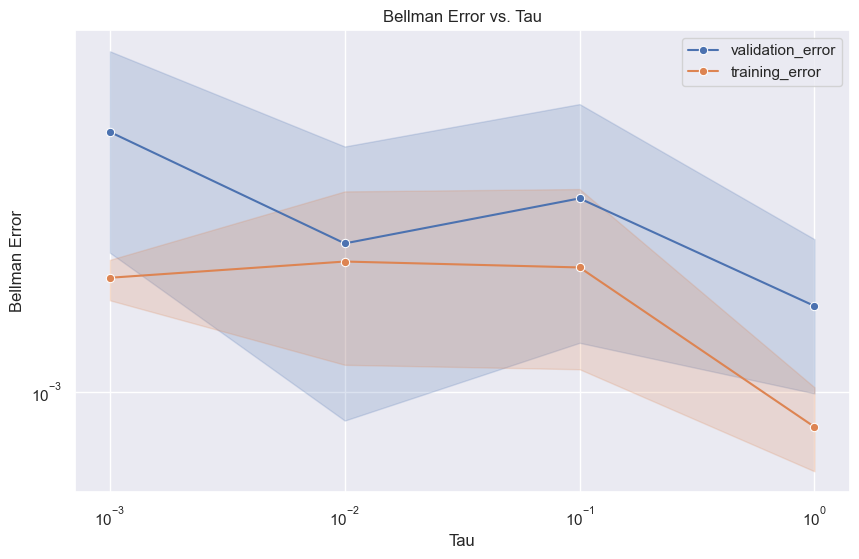

In [175]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=bellman_errors_df_melted,
    x="tau",
    y="error_value",
    hue="error_type",
    marker="o",
    # errorbar=("pi", 100),
    errorbar="ci"
    # label="Bellman Error",
)
plt.xlabel("Tau")
plt.ylabel("Bellman Error")
plt.xscale("log")
plt.yscale("log")
plt.title("Bellman Error vs. Tau")
plt.legend()
plt.show()

In [176]:
# baseline_dir = r".\results\2024Apr12-105805_baseline_configs" # adam
baseline_dir = r".\results\2024Apr13-163412_baseline_configs" # sgd

baseline_errors_df = collect_bellman_errors(baseline_dir)
baseline_errors_df


,run_id,tau,min_samples,validation_error,training_error
0,0,1,10,0.000325,0.000827
1,1,1,10,NaN,NaN
2,10,1,10,0.000153,0.001846
3,11,1,10,0.022270,0.001615
4,12,1,10,0.004856,0.001063
5,13,1,10,0.002455,0.001403
6,14,1,10,0.002963,0.001735
7,15,1,10,0.000275,0.000698
8,16,1,10,0.001802,0.001133
9,17,1,10,0.000292,0.001002


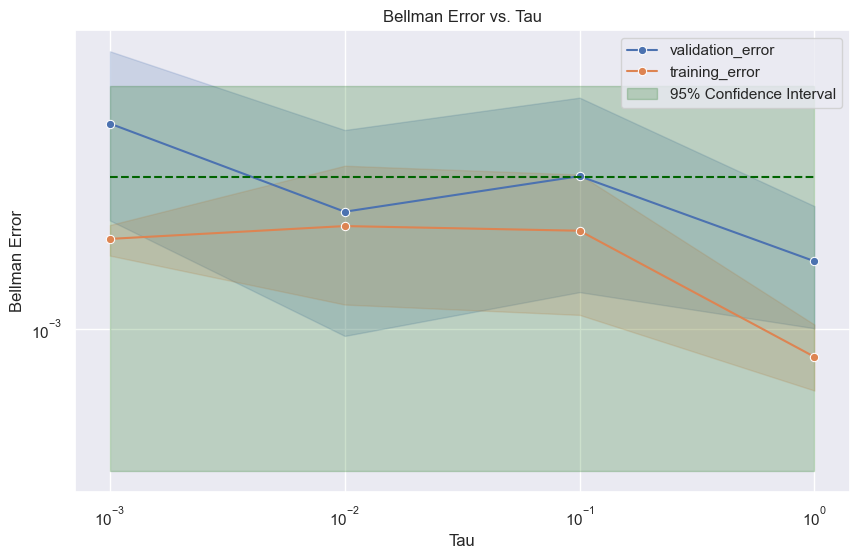

In [210]:
# Assuming baseline_errors_df is your dataframe
n = len(baseline_errors_df['validation_error'])  # Number of samples
baseline_avg_bellman_error = baseline_errors_df['validation_error'].mean()
baseline_std_dev = baseline_errors_df['validation_error'].std()
baseline_sem = sem(baseline_errors_df['validation_error'], nan_policy='omit')  # Calculate the SEM

# Confidence interval calculation (95% confidence)
t_critical = t.ppf(0.975, n-1)  # Two-tailed t-value for 95% confidence
ci_range = t_critical * baseline_sem

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=bellman_errors_df_melted,
    x="tau",
    y="error_value",
    hue="error_type",
    marker="o",
    errorbar="ci"  # This defaults to 95% CI
)

tau_min = bellman_errors_df['tau'].min()
tau_max = bellman_errors_df['tau'].max()

# Plot the mean line
plt.plot([tau_min, tau_max], [baseline_avg_bellman_error, baseline_avg_bellman_error], linestyle='--', color='darkgreen')

# Plot the confidence interval around the mean
x_values = np.logspace(np.log10(tau_min), np.log10(tau_max), num=100)

plt.fill_between(x_values, 
                 [baseline_avg_bellman_error - ci_range] * len(x_values), 
                 [baseline_avg_bellman_error + ci_range] * len(x_values), 
                 color='darkgreen', alpha=0.2, label='95% Confidence Interval')

plt.xlabel("Tau")
plt.ylabel("Bellman Error")
plt.xscale("log")
plt.yscale("log")
plt.title("Bellman Error vs. Tau")
plt.legend()

plt.show()

In [208]:
print("Sample size (n):", n)
print("Standard Deviation:", baseline_std_dev)
if n > 1:
    baseline_sem = sem(baseline_errors_df['validation_error'], nan_policy='omit')  # Adjust SEM calculation
    t_critical = t.ppf(0.975, n-1)
    ci_range = t_critical * baseline_sem
    print("CI Range:", ci_range)
else:
    print("Not enough data to compute CI.")
print("CI Range:", ci_range)
print("Mean Error:", baseline_avg_bellman_error)
print("X Values Range:", x_values.min(), x_values.max())

Sample size (n): 20
Standard Deviation: 0.005127656964357677
CI Range: 0.0024621606300505245
CI Range: 0.0024621606300505245
Mean Error: 0.002839364516579448
X Values Range: 0.001 1.0


In [189]:
specific_tau = 1  # Set the specific tau value you are interested in
filtered_df = bellman_errors_df_melted[bellman_errors_df_melted['tau'] == specific_tau]

baseline_melted = pd.melt(baseline_errors_df, id_vars=['run_id', 'tau', 'min_samples'], value_vars=['validation_error', 'training_error'], var_name='error_type', value_name='error_value')
baseline_melted['source'] = 'Baseline'  # Add a source column to indicate these are from baseline
# baseline_melted['error_type'] = baseline_melted['error_type'].replace({'validation_error': 'Validation', 'training_error': 'Training'})  # Rename for clarity

# Assuming df1 is your experimental data and already melted
filtered_df['source'] = 'Experiment'  # Indicate these are experimental data

# Combine the two datasets
combined_df = pd.concat([filtered_df, baseline_melted], ignore_index=True)
combined_df

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_21168\1692046549.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['source'] = 'Experiment'  # Indicate these are experimental data


,run_id,tau,min_samples,error_type,error_value,source
0,0,1.0,10,validation_error,0.000289,Experiment
1,1,1.0,10,validation_error,0.002261,Experiment
2,10,1.0,10,validation_error,0.000248,Experiment
3,11,1.0,10,validation_error,0.006288,Experiment
4,12,1.0,10,validation_error,0.003623,Experiment
...,...,...,...,...,...,...
75,5,1.0,10,training_error,0.000958,Baseline
76,6,1.0,10,training_error,0.001315,Baseline
77,7,1.0,10,training_error,0.001233,Baseline
78,8,1.0,10,training_error,0.000961,Baseline


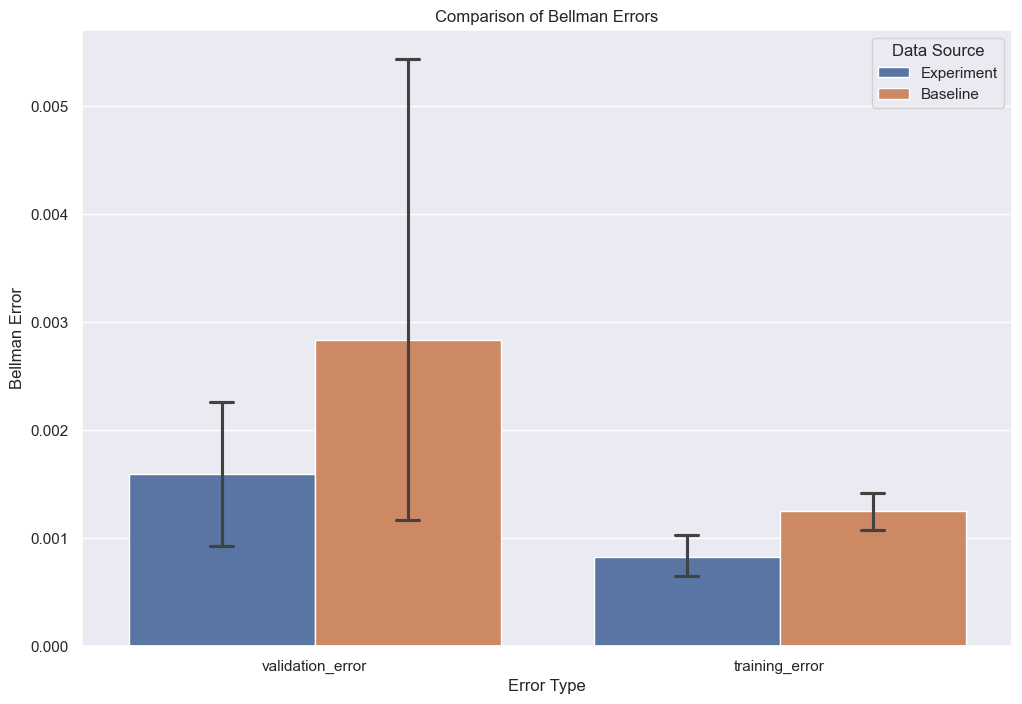

In [190]:
plt.figure(figsize=(12, 8))
sns.barplot(data=combined_df, x='error_type', y='error_value', hue='source', capsize=.1)

# Adding labels and titles
plt.xlabel("Error Type")
plt.ylabel("Bellman Error")
plt.title("Comparison of Bellman Errors")
plt.legend(title="Data Source")

plt.show()

In [180]:
# use mdp to generate transition distribution
# this generates another dataset of transitions

# then apply:
# ### Training
# input_size = len(states[0])  # Or another way to represent the size of your input
# output_size = len(actions)

# # Initialize the DQN
# dqn = DQN(input_size, output_size)

# loss_record = train_dqn(
#     dqn,
#     sampled_transitions_train,
#     Q_pi_random,
#     states,
#     actions,
#     gamma,
#     epsilon,
#     batch_size=batch_size,
#     max_iterations=train_max_iterations,
#     logger=logger,
# )

# bm_error = compute_bellmans_error(
#     dqn, validation_transitions=transitions_val, gamma=gamma
# )

### AND

# policy evaluation

# plot both

In [181]:
# do policy evaluation on train datasets -> Q
# Evaluate with Q on validation set

# training DQN == value iteration
# we want to do policy evaluation with DQN (we do this by changing the loss function with bellman equation for Q pi instead of Q*)
# if we want to do early stopping, do it with Q* instead of Q pi random